In [1]:
import numpy as np

### Definição de funções para visualização em grid da função valor e da política

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

def PlotValues(v, gridSide, k):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    cmap = plt.cm.get_cmap('autumn')

    im = ax.imshow(v.reshape(gridSide, gridSide), cmap=cmap)
    ax.set_title(f'Value Function for k = {k}')

    for i in range(gridSide):
        for j in range(gridSide):
          ax.text(j, i, f'{v[i * gridSide + j]:.1f}', ha='center', va='center', color='k')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)

    for i in range(1, gridSide):
      ax.axhline(i - 0.5, color='black', linewidth=1)
      ax.axvline(i - 0.5, color='black', linewidth=1)

    plt.show()

def PlotValuesAndPolicy(v, policy, gridSide):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    originalActions = ["↑", "←", "↓", "→"]

    cmap = plt.cm.get_cmap('autumn')

    im1 = ax[0].imshow(v.reshape(gridSide, gridSide), cmap=cmap)
    ax[0].set_title('Value Function')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[0].tick_params(axis='both', which='both', length=0)
    for i in range(gridSide):
        for j in range(gridSide):
          ax[0].text(j, i, f'{v[i * gridSide + j]:.1f}', ha='center', va='center', color='k')

    for i in range(1, gridSide):
      ax[0].axhline(i - 0.5, color='black', linewidth=1)
      ax[0].axvline(i - 0.5, color='black', linewidth=1)

    im2 = ax[1].imshow(np.zeros((gridSide, gridSide), dtype=int), cmap=cmap, vmin=0, vmax=len(originalActions))
    ax[1].set_title('Policy Actions')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
    ax[1].tick_params(axis='both', which='both', length=0)

    for i in range(1, gridSide):
      ax[1].axhline(i - 0.5, color='black', linewidth=1)
      ax[1].axvline(i - 0.5, color='black', linewidth=1)

    for i in range(gridSide):
        for j in range(gridSide):
            actions = policy[i * gridSide + j]
            actionString = ""
            for action in originalActions:
              if action in actions:
                actionString += action
            ax[1].text(j, i, actionString, ha='center', va='center', color='k')

    #fig.colorbar(im1, ax=ax[0])

    plt.show()

### Definição do ambiente

In [3]:
class GridWorld:
    def __init__(self, gridSide, gamma, rewards, endStates):
        self.gridSide = gridSide
        self.gamma = gamma
        self.rewards = rewards
        self.endStates = endStates

    def GetStates(self):
      return [i for i in range(self.gridSide ** 2)]

    def DistributionFunction(self, reward, newState, prevState, action):
      return 1

    # movimentos que levam a bater em uma das bordas resultam em permanência no mesmo estado
    def MapNextStates(self, currentState, actions):
      nextStates = []

      # verifica se não está na borda direita do grid
      if "→" in actions:
        if currentState % self.gridSide != self.gridSide - 1: nextStates.append(currentState + 1)
        else: nextStates.append(currentState)

      # verifica se não está na borda esquerda do grid
      if "←" in actions:
        if currentState % self.gridSide != 0: nextStates.append(currentState - 1)
        else: nextStates.append(currentState)

      # verifica se não está na linha superior do grid
      if "↑" in actions:
        if currentState >= self.gridSide: nextStates.append(currentState - self.gridSide)
        else: nextStates.append(currentState)

      # verifica se não está na linha inferior do grid
      if "↓" in actions:
        if currentState < len(self.GetStates()) - self.gridSide: nextStates.append(currentState + self.gridSide)
        else: nextStates.append(currentState)

      return nextStates

    def ExpectedReturn(self, state, actions, values):
      stateValue = 0
      actionProb = 1/len(actions) if len(actions) > 0 else 0
      if state not in self.endStates:
        nextStates = self.MapNextStates(state, actions)
        for i in range(len(actions)):
          stateValue += (actionProb *
                    self.DistributionFunction(self.rewards[nextStates[i]], nextStates[i], state, actions[i]) *
                    (self.rewards[nextStates[i]] + self.gamma * values[nextStates[i]]))

      return stateValue

### IPE com atualização dos valores em outro array

Essa primeira versão do IPE é a versão normalmente utilizada, por sua maior eficiência. Os valores obtidos a cada iteração já são atualizados no próprio vetor criado para armazenar a função valor em cada estado, de forma que a convergência é mais rápida.

In [4]:
def IterativePolicyEvaluation2arrays(env, values, policy, theta):
  k = 0 # número da iteração
  delta = theta
  valuesStore = np.copy(values)
  valuesUpdate = np.zeros(len(env.GetStates()))
  while delta >= theta:
    delta = 0
    for state in range(len(env.GetStates())):
      valuesUpdate[state] = env.ExpectedReturn(state, policy[state], valuesStore)
      delta = max(delta, abs(valuesUpdate[state] - valuesStore[state]))
    valuesStore = np.copy(valuesUpdate)
    k += 1
    if k == 1 or k == 2 or k == 3 or k == 10 or delta < theta:
      PlotValues(valuesStore, env.gridSide, k)

  return valuesStore

IPE with 2 value function arrays


C:\Users\viana\AppData\Local\Temp\ipykernel_8452\1118497546.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('autumn')


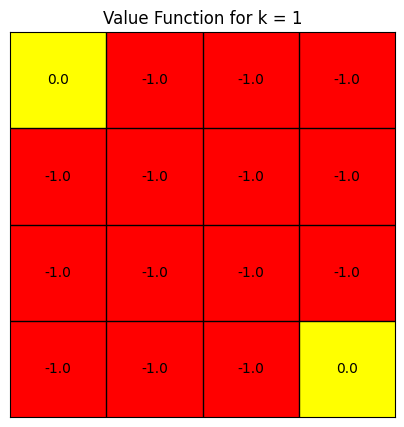

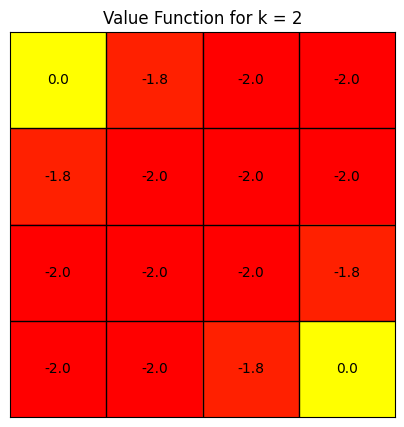

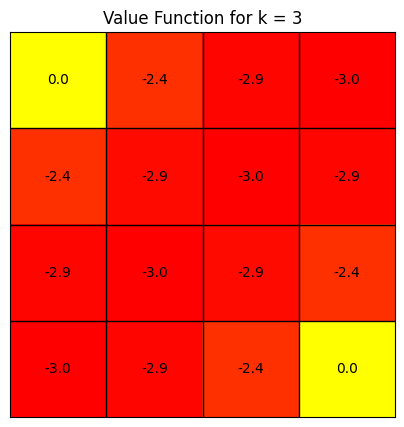

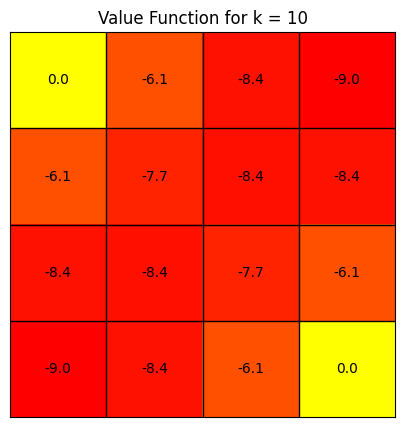

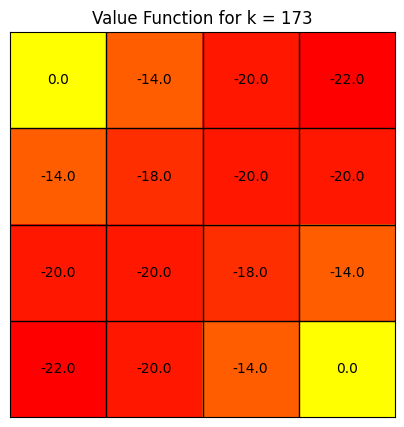

In [5]:
# inicializando o ambiente
gridSide = 4
gamma = 1
rewards = [-1] * gridSide ** 2
endStates = [0, gridSide ** 2 - 1]

env = GridWorld(gridSide, gamma, rewards, endStates)

# DP
initialValues = np.zeros(gridSide ** 2)
policy = [["↑", "←", "↓", "→"]] * gridSide ** 2
theta = 0.0001

print("IPE with 2 value function arrays")
values = IterativePolicyEvaluation2arrays(env, initialValues, np.array(policy, dtype=object), theta)

### IPE com atualização dos valores no próprio array da função valor

Nessa segunda versão, é criado um novo vetor separado apenas para guardar os valores atualizados, de forma que os novos valores obtidos são todos em relação a valores antigos da função valor. Como resultado, a convergência foi obtida para um número de iterações maior do que anteriormente.

In [6]:
def IterativePolicyEvaluation(env, values, policy, theta):
  k = 0 # número da iteração
  delta = theta
  while delta >= theta:
    delta = 0
    for state in range(len(env.GetStates())):
      oldValue = values[state]
      values[state] = env.ExpectedReturn(state, policy[state], values)
      delta = max(delta, abs(values[state] - oldValue))
    k += 1
    if k == 1 or k == 2 or k == 3 or k == 10 or delta < theta:
      PlotValues(values, env.gridSide, k)

  return values

IPE updating values in original array


C:\Users\viana\AppData\Local\Temp\ipykernel_8452\1118497546.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('autumn')


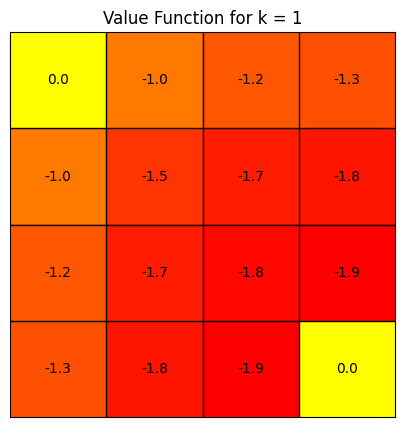

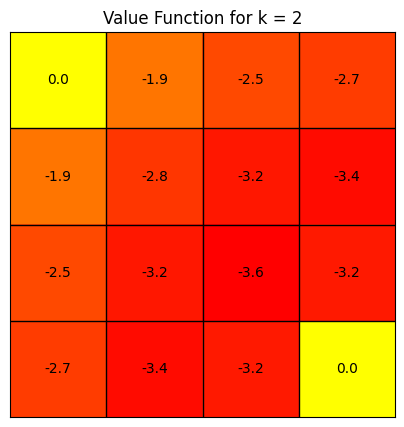

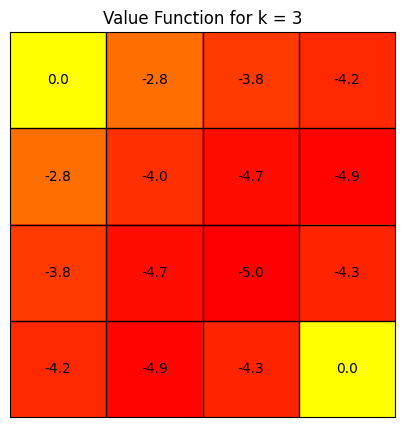

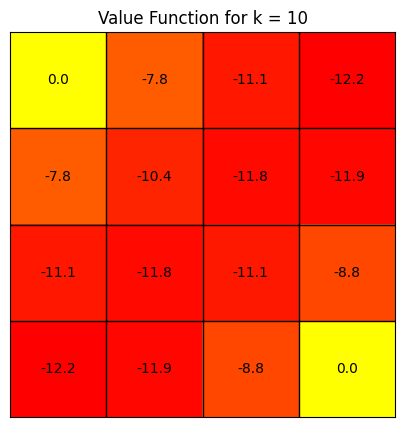

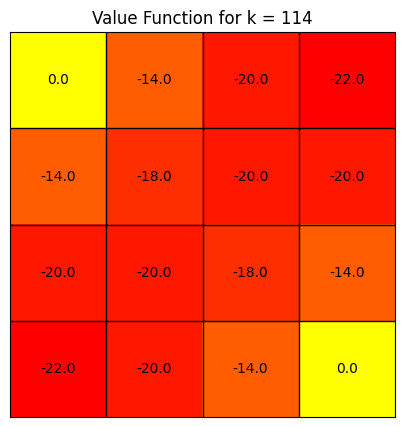

In [7]:
# inicializando o ambiente
gridSide = 4
gamma = 1
rewards = [-1] * gridSide ** 2
endStates = [0, gridSide ** 2 - 1]

env = GridWorld(gridSide, gamma, rewards, endStates)

# DP
initialValues = np.zeros(gridSide ** 2)
policy = [["↑", "←", "↓", "→"]] * gridSide ** 2
theta = 0.0001

print("IPE updating values in original array")
values = IterativePolicyEvaluation(env, initialValues, np.array(policy, dtype=object), theta)

### Algoritmo Policy Iteration

Seguindo o algoritmo, a política obtida é determinística por selecionar a ação gananciosa em respeito a função valor obtida na etapa de Policy Evaluation. Assim, embora possa existir mais de uma ação com função valor máxima em um estado, a política apresenta apenas uma delas.

In [8]:
def PolicyEvaluation(env, values, policy, theta):
  delta = theta
  while delta >= theta:
    delta = 0
    for state in range(len(env.GetStates())):
      oldValue = values[state]
      values[state] = env.ExpectedReturn(state, policy[state], values)
      delta = max(delta, abs(values[state] - oldValue))

  return values

def PolicyImprovement(env, values, policy, actions):
  for state in range(len(env.GetStates())):
    maxValue = float('-inf')
    for action in actions:
      value = env.ExpectedReturn(state, [action], values)
      if round(value, 3) > round(maxValue, 3):
        greedyAction = [action]
        maxValue = value
    if state not in env.endStates: policy[state] = greedyAction

  return policy

def PolicyIteration(env, values, policy, actions, theta):
  policyStable = False
  while not policyStable:
    oldPolicy = np.copy(policy)
    policyStable = True
    values = PolicyEvaluation(env, values, policy, theta)
    policy = PolicyImprovement(env, values, policy, actions)
    if (policy != oldPolicy).any(): policyStable = False

    PlotValuesAndPolicy(values, policy, env.gridSide)

  return values, policy

PI for determinstic policy


C:\Users\viana\AppData\Local\Temp\ipykernel_8452\1118497546.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('autumn')


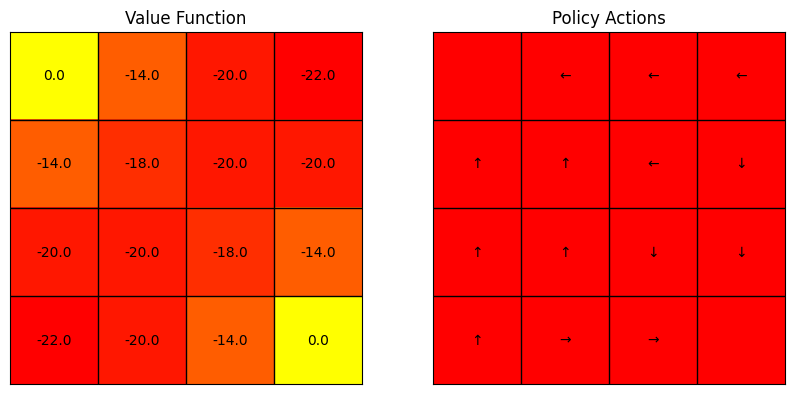

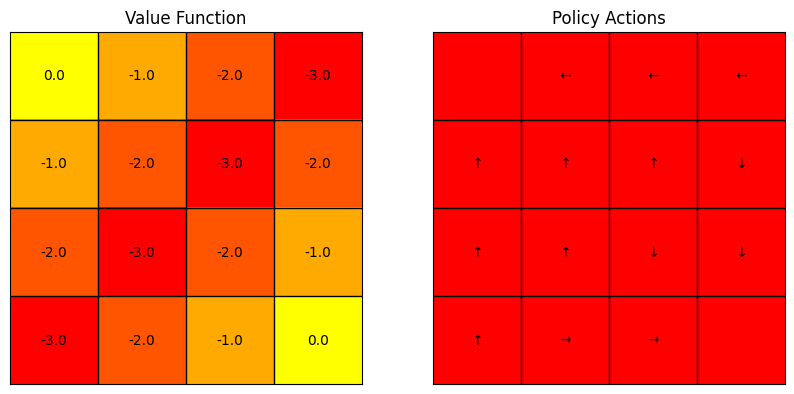

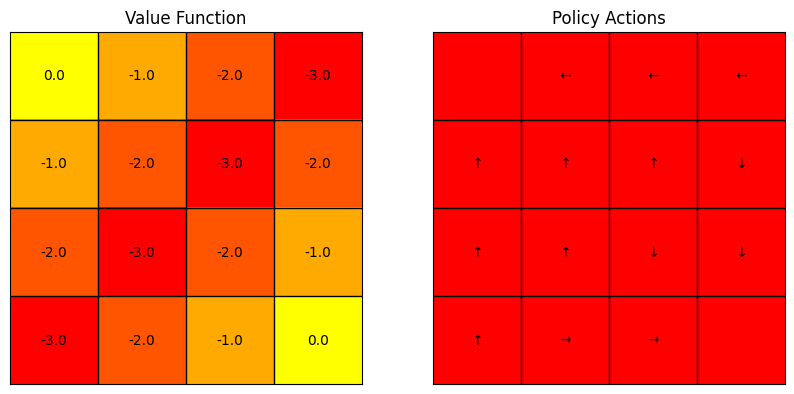

In [9]:
# inicializando o ambiente
gridSide = 4
gamma = 1
rewards = [-1] * gridSide ** 2
endStates = [0, gridSide ** 2 - 1]

env = GridWorld(gridSide, gamma, rewards, endStates)

# DP
initialValues = np.zeros(gridSide ** 2)
actions = ["↑", "←", "↓", "→"]
initialPolicy = []
for i in range(gridSide ** 2):
  if (i != 0 and i != gridSide ** 2 - 1): initialPolicy.append(actions)
  else: initialPolicy.append([])
theta = 0.001

print("PI for determinstic policy")
values, policy = PolicyIteration(env, initialValues, np.array(initialPolicy, dtype=object), actions, theta)

### Policy Iteration modificado para obter todas as ações gananciosas


Nessa versão, foi criado um vetor de ações gananciosas para armazenar todas as ações com função valor máxima. Para isso, utilizou-se também um arredondamento em 3 casas decimais na função valor, para que o algoritmo funcionasse como o esperado, tendo em vista que os valores são aproximações do valor real e as operações envolvendo aritmética do ponto flutuante, o que pode fazer com que a comparação simples não retorne a política estocástica com todas as ações.

In [10]:
def PolicyEvaluation(env, values, policy, theta):
  delta = theta
  while delta >= theta:
    delta = 0
    for state in range(len(env.GetStates())):
      oldValue = values[state]
      values[state] = env.ExpectedReturn(state, policy[state], values)
      delta = max(delta, abs(values[state] - oldValue))

  return values

def ObtainStochasticPolicy(env, values, policy, actions):
  for state in range(len(env.GetStates())):
    maxValue = float('-inf')
    greedyActions = []
    for action in actions:
      value = env.ExpectedReturn(state, [action], values)
      if round(value, 3) > round(maxValue, 3):
        greedyActions = [action]
        maxValue = value
      elif round(value, 3) == round(maxValue, 3):
        greedyActions.append(action)
    if state not in env.endStates: policy[state] = greedyActions

  return policy

def StochasticPolicyIteration(env, values, policy, actions, theta):
  policyStable = False
  while not policyStable:
    oldPolicy = np.copy(policy)
    policyStable = True
    values = PolicyEvaluation(env, values, policy, theta)
    policy = ObtainStochasticPolicy(env, values, policy, actions)
    if (policy != oldPolicy).any(): policyStable = False

    PlotValuesAndPolicy(values, policy, env.gridSide)

  return values, policy

Stochastic policy


C:\Users\viana\AppData\Local\Temp\ipykernel_8452\1118497546.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('autumn')


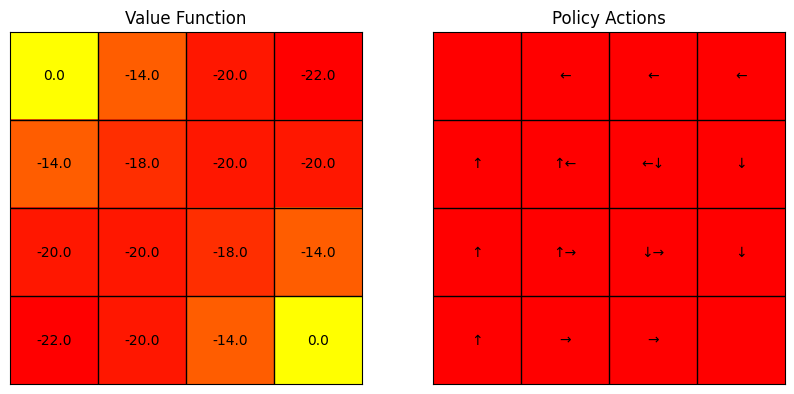

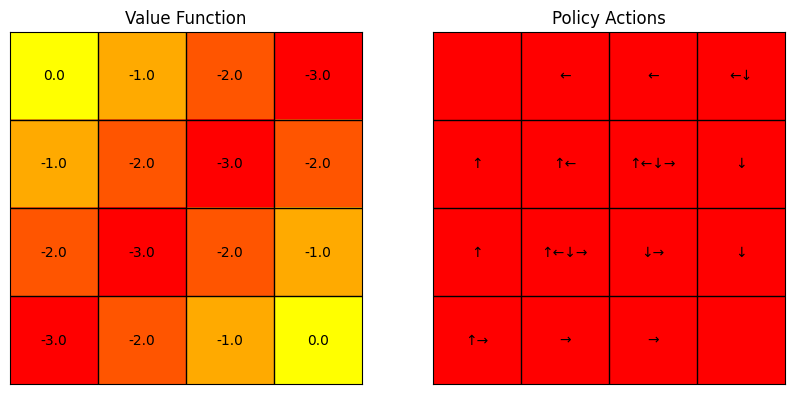

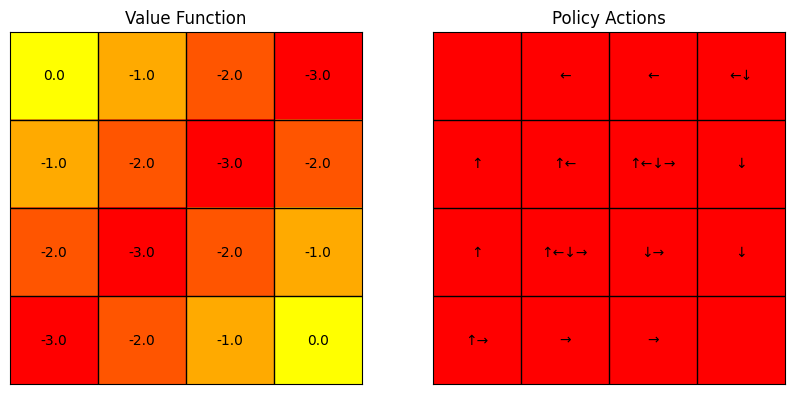

In [11]:
# inicializando o ambiente
gridSide = 4
gamma = 1
rewards = [-1] * gridSide ** 2
endStates = [0, gridSide ** 2 - 1]

env = GridWorld(gridSide, gamma, rewards, endStates)

# DP
initialValues = np.zeros(gridSide ** 2)
actions = ["↑", "←", "↓", "→"]
initialPolicy = []
for i in range(gridSide ** 2):
  if (i != 0 and i != gridSide ** 2 - 1): initialPolicy.append(actions)
  else: initialPolicy.append([])
theta = 0.001

print("Stochastic policy")
values, policy = StochasticPolicyIteration(env, initialValues, np.array(initialPolicy, dtype=object), actions, theta)

### Value Iteration (algoritmo generalizado)

O algoritmo generalizado não espera a função valor de fato convergir, pois a regra de atualização passa a ser em função da ação gananciosa. Dessa forma, o número de iterações para obter a política ideal é maior do que no algoritmo de Policy Iteration.

In [12]:
def GetGreedyAction(env, state, values, actions):
  maxValue = float('-inf')
  for action in actions:
    value = env.ExpectedReturn(state, [action], values)
    if round(value, 3) > round(maxValue, 3):
      greedyAction = [action]
      maxValue = value

  return greedyAction

def ValueIteration(env, values, policy, actions, theta):
  delta = theta
  while delta >= theta:
    delta = 0
    for state in range(len(env.GetStates())):
      oldValue = values[state]
      if(state != 0): policy[state] = GetGreedyAction(env, state, values, actions)
      values[state] = env.ExpectedReturn(state, policy[state], values)
      delta = max(delta, abs(values[state] - oldValue))
    PlotValuesAndPolicy(values, policy, env.gridSide)

  return policy

Value Iteration


C:\Users\viana\AppData\Local\Temp\ipykernel_8452\1118497546.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('autumn')


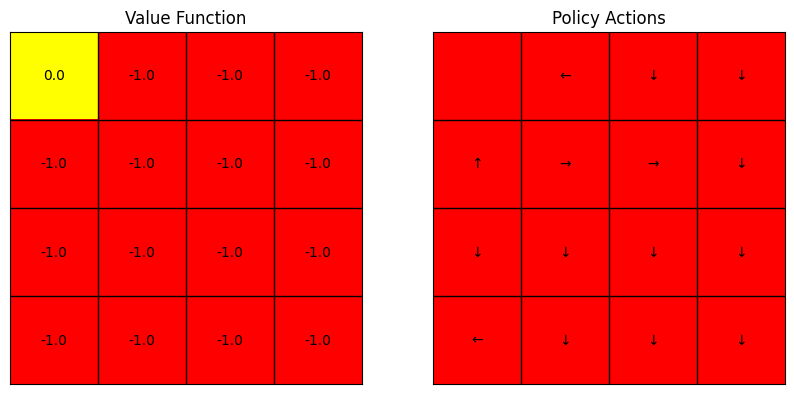

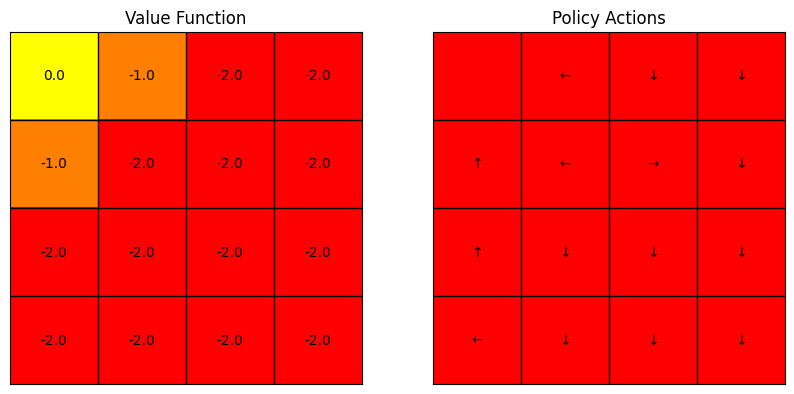

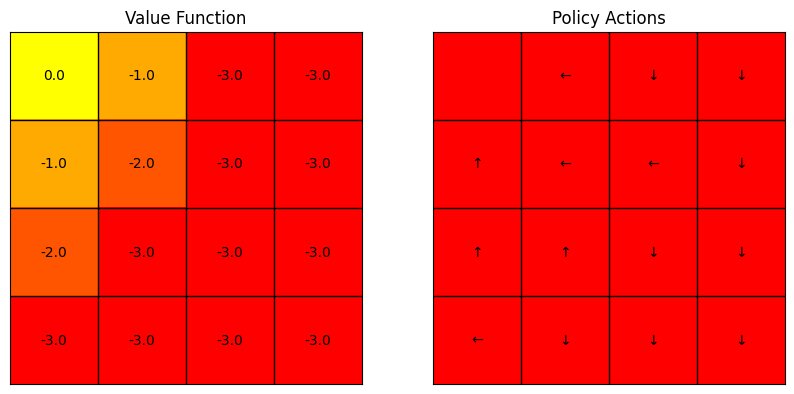

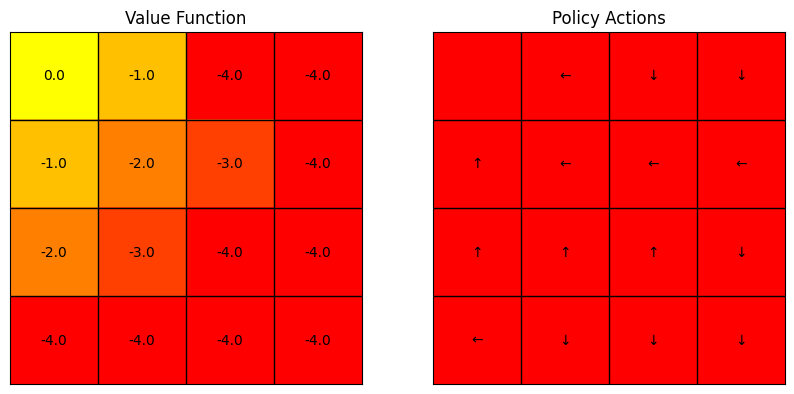

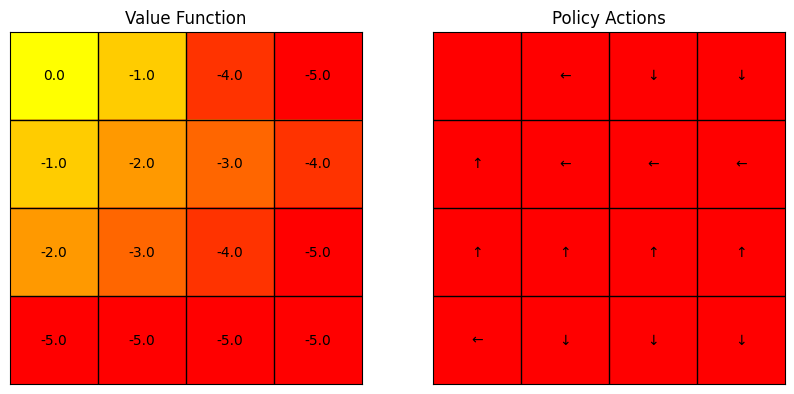

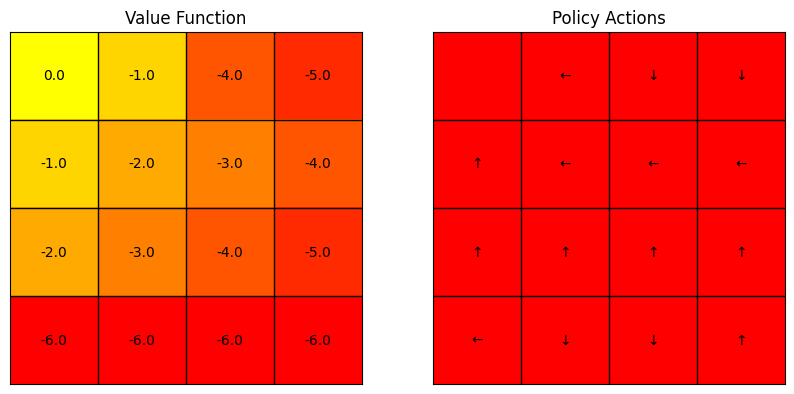

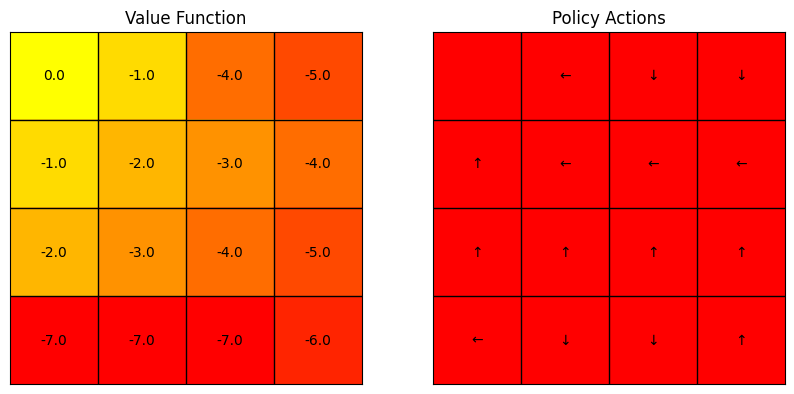

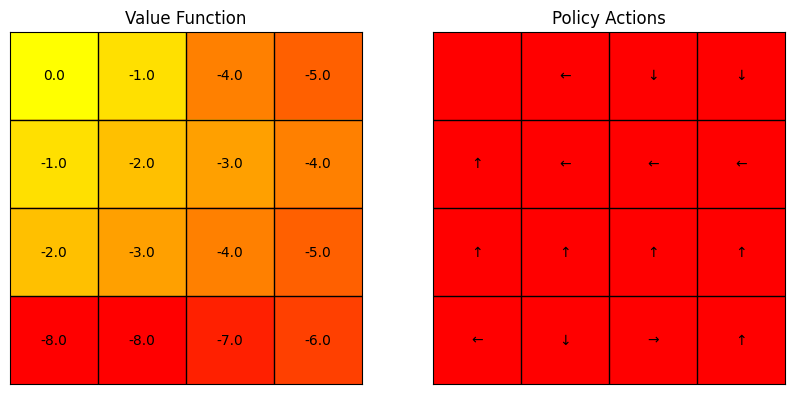

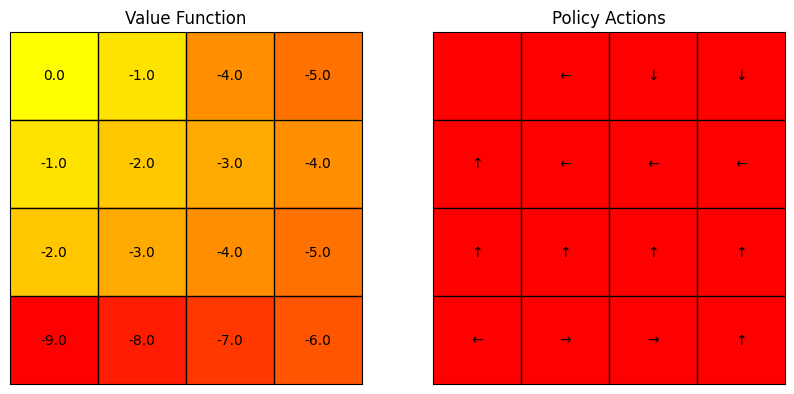

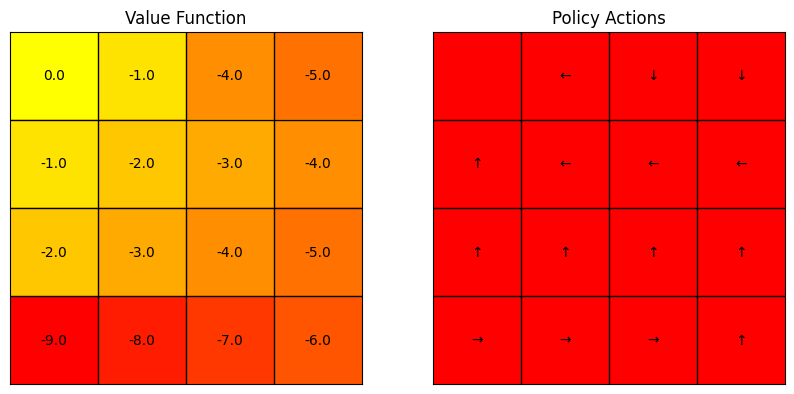

In [13]:
# inicializando o ambiente
gridSide = 4
gamma = 1
for i in [1,2,3,8,9,10]:
    rewards[i] = -10
endStates = [0]

env = GridWorld(gridSide, gamma, rewards, endStates)

# DP
initialValues = np.zeros(gridSide ** 2)
actions = ["↑", "←", "↓", "→"]
initialPolicy = []
for i in range(gridSide ** 2):
  if (i != 0): initialPolicy.append(actions)
  else: initialPolicy.append([])
theta = 0.001

print("Value Iteration")
policy = ValueIteration(env, initialValues, np.array(initialPolicy, dtype=object), actions, theta)

### Comparando com Policy Iteration

Utilizando Policy Iteration converge mais rapidamente do que utilizando o algoritmo generalizado, sendo que foram necessárias apenas 6 iterações, enquanto para o Value Iteration foram 10.



Policy Iteration


C:\Users\viana\AppData\Local\Temp\ipykernel_8452\1118497546.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('autumn')


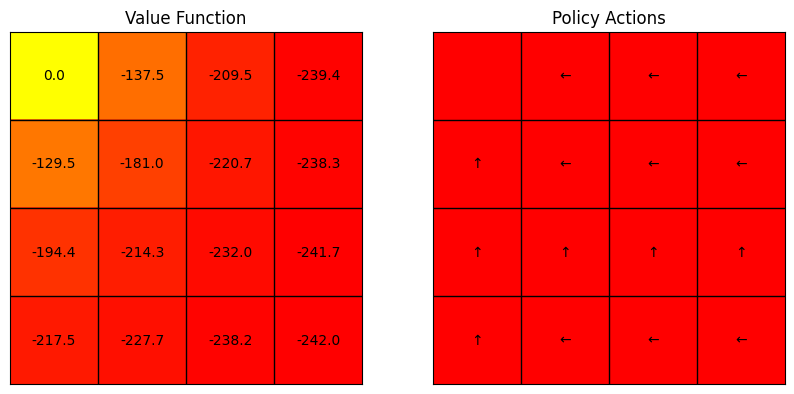

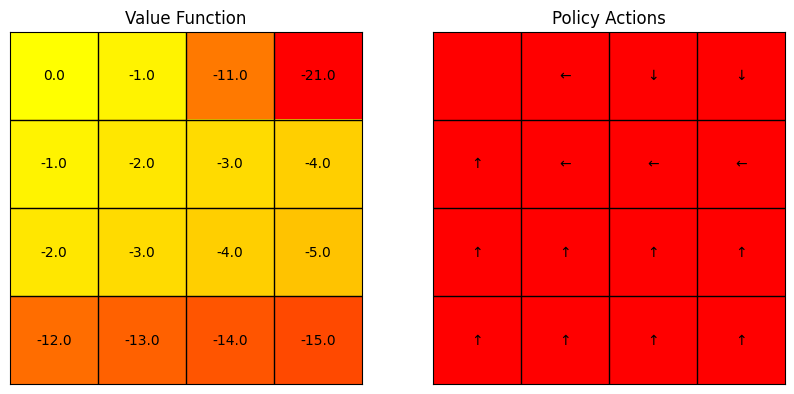

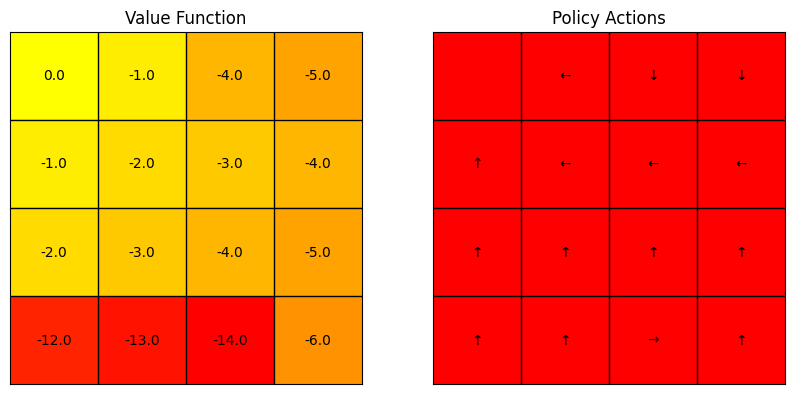

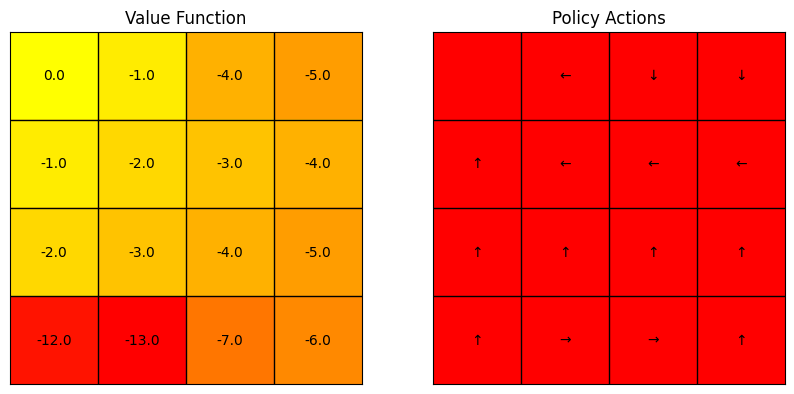

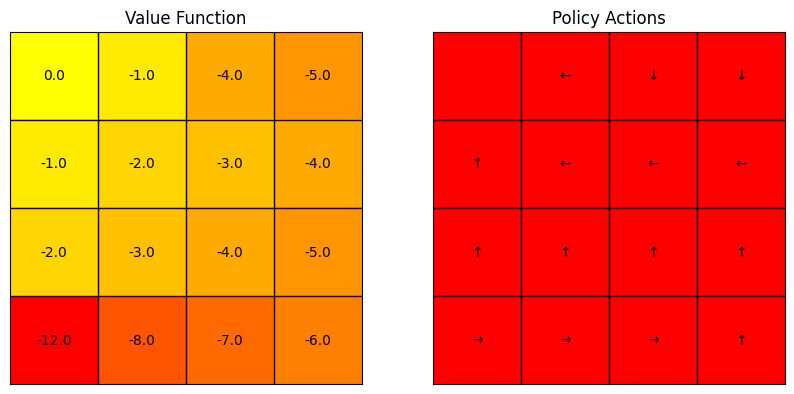

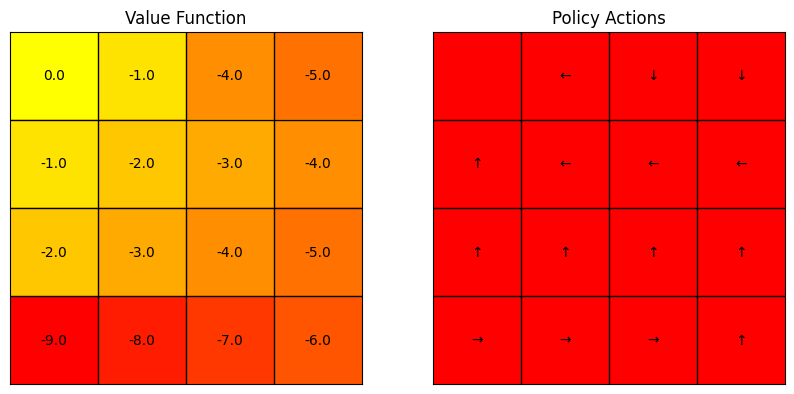

In [14]:
# inicializando o ambiente
gridSide = 4
gamma = 1
for i in [1,2,3,8,9,10]:
    rewards[i] = -10
endStates = [0]

env = GridWorld(gridSide, gamma, rewards, endStates)

# DP
initialValues = np.zeros(gridSide ** 2)
actions = ["↑", "←", "↓", "→"]
initialPolicy = []
for i in range(gridSide ** 2):
  if (i != 0): initialPolicy.append(actions)
  else: initialPolicy.append([])
theta = 0.001

print("Policy Iteration")
values, policy = PolicyIteration(env, initialValues, np.array(initialPolicy, dtype=object), actions, theta)